## Introduction: Literary Text Classification using SVM

This project builds a **text classifier** that maps user queries to one of **11 English literary classics**, such as _Pride and Prejudice_, _Frankenstein_, and _The Great Gatsby_. It is part of a larger project designed to reduce hallucinations in LLM-based question answering by routing queries to the correct knowledge base using document classification.

The current model classifies queries or document segments into the following books:

- _Alice’s Adventures in Wonderland_
- _Little Women_
- _Sherlock Holmes_
- _The Adventures of Tom Sawyer_
- _Pride and Prejudice_
- _Anne of Green Gables_
- _Oliver Twist_
- _Frankenstein_
- _The Importance of Being Earnest_
- _Great Expectations_
- _The Great Gatsby_

## Project Purpose :

This text classification module is a **subcomponent of a Retrieval-Augmented Generation (RAG) system**, aimed at:

- Improving response accuracy by guiding the user’s query to the correct corpus
- Enabling LLMs to generate grounded answers using a verified source (also being able to show the source of text in a book)


## Model Choice:  SVM
Initially, the system used zero-shot and few-shot classification with general-purpose LLMs. However, these models showed inconsistent results with unseen or stylistic queries.

- Support Vector Machines (SVMs) were adopted due to their:

- Effectiveness in high-dimensional spaces (TF-IDF vectors)

- Robustness on small- to medium-sized datasets

- Strong generalization when tuned properly


## Tools and Libraries Used:
Python Libraries: sklearn, nltk, spacy, pandas, matplotlib, joblib

- NLP Preprocessing: Lemmatization, stopword removal, Named Entity Recognition (NER)

- Text Representation: TF-IDF Vectorizer (with n-grams)

- Classifier: sklearn.svm.SVC (Support Vector Machine with linear kernel)

- Evaluation: Accuracy, Classification Report, Confusion Matrix, t-SNE

- Future Stack: The full RAG system is expected to integrate embeddings, LLMs, Prompt Engineering, and a React-based UI.


## Project Workflow:

Below steps describe the steps of usual training of semantic/supervised classification tasks/model training.

- Data Extraction: Load and extract 11 classic books in .txt format

- Preprocessing: Tokenization, lemmatization, NER-based boosting

- Chunking: Books split into consistent-length passages for classification

- Vectorization: TF-IDF applied over preprocessed text chunks

- Modeling: SVM classifier trained and evaluated

- Inference: Given a user query, predict the most relevant book

- Export: Model saved as .pkl for future use or integration



In [ ]:
#Importing Packages
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Data Preprocessing

import zipfile
import re
import spacy

#Spacy model loaded to help with name boosting the novel characters and places
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def ner_boost(text, boost_factor=3):
    """
    Boost named entities in the input text by repeating them.
    This is to increase their weight during TF-IDF vectorization.
    """
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ("PERSON", "GPE", "ORG")]

    # Repeat each entity `boost_factor` times
    for ent in entities:
        text += (" " + ent) * (boost_factor - 1)  # already appears once
    return text

# Function to preprocess text (lemmatization + stopword removal)
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words
    ]
    return " ".join(processed_tokens)  # Join back to string

# Function to extract ZIP file
def extract_zip(zip_path, extract_to="extracted_files"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Books extracted to {extract_to}")

# Function to split text into chunks
def split_text_into_chunks(text, words_per_chunk=1000):
    words = text.split()
    return [' '.join(words[i:i+words_per_chunk]) for i in range(0, len(words), words_per_chunk)]


# Extract books
zip_path = "chatbot_books.zip"
books_dir = "extracted_files"
extract_zip(zip_path, books_dir)

# Load book texts
texts, labels = [], []
label_to_book = {}


def process_books(file_directory):
    dir_list = os.listdir(file_directory)
    for book_file in dir_list:
        if book_file.endswith('.txt'):
            print(f"Processing book: {book_file}")
            full_path = os.path.join(file_directory, book_file)
            label_to_book[len(label_to_book)] = book_file.replace(".txt", "")

            with open(full_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                content = preprocess_text(content)  # Apply preprocessing
                chunks = split_text_into_chunks(content)
                texts.extend(chunks)
                labels.extend([len(label_to_book) - 1] * len(chunks))  # Assign label based on order

process_books("extracted_files/chatbot_books")

# Boosting character, locations etc. using NER
texts= [ner_boost(t) for t in texts]


In [ ]:
print(f"Number of texts: {len(texts)}")
print(f"Number of labels: {len(labels)}")

Number of texts: 283
Number of labels: 283


In [ ]:
#Creating the Dataset for training the SVM Model
import pandas as pd

# Define the file name
csv_filename = "texts_labels.csv"

# Create a DataFrame
df = pd.DataFrame({"Text": texts, "Label": labels})

#print rows and labels
print(df.head())

# Append data to the CSV file (or create it if it doesn't exist)
df.to_csv(csv_filename, index=False, mode="a", header=not os.path.exists(csv_filename))

                                                Text  Label
0  project gutenberg ebook alice adventure wonder...      0
1  small one choked patted back however last sat ...      0
2  everything within reach duchess baby came firs...      0
3  alice dear said sister long sleep oh curious d...      0
4  including make donation project gutenberg lite...      0


## Data Visualisation:

- To explore the data present in the corpus, we will try to plot the length of chunks.

- As we can see from below histogram , because of unequal lengths of the corpus , we can expect because the samples are low, lower accuracy for corpus with lower chunks.

- We could appropriately divide the test and training samples so that we can train the model in that ratio instead of randomly dividing the chunks of text.



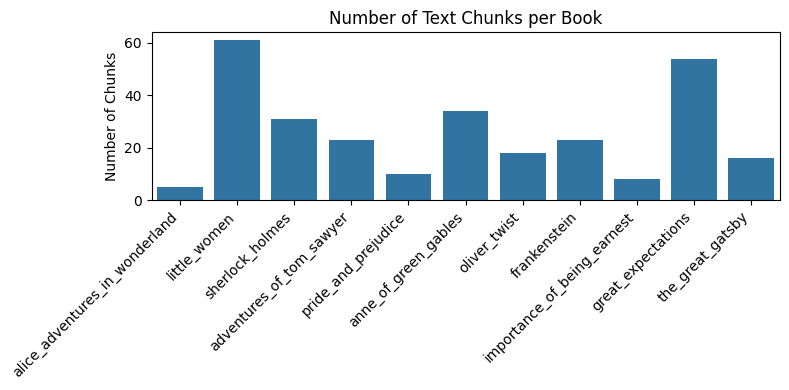

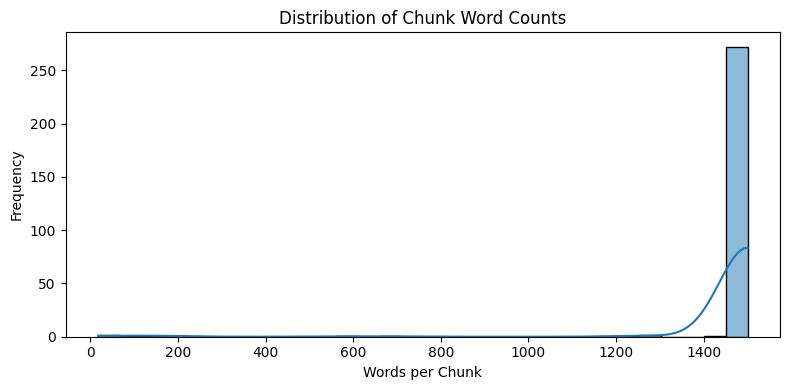

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Create a DataFrame with texts and labels
df = pd.DataFrame({"Text": texts, "Label": labels})


# Display count number of chunks per label
label_counts = pd.Series(labels).value_counts().sort_index()
book_names = [label_to_book[i] for i in label_counts.index]

plt.figure(figsize=(8, 4))
sns.barplot(x=book_names, y=label_counts.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Chunks")
plt.title("Number of Text Chunks per Book")
plt.tight_layout()
plt.show()


# Calculate word count for each chunk
chunk_lengths = [len(text.split()) for text in texts]

plt.figure(figsize=(8, 4))
sns.histplot(chunk_lengths, bins=30, kde=True)
plt.xlabel("Words per Chunk")
plt.ylabel("Frequency")
plt.title("Distribution of Chunk Word Counts")
plt.tight_layout()
plt.show()

In [ ]:
#Model Training and Evaluation
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Vectorize text using TF-IDF (with stopword removal handled manually)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))# n-grams to make sense of bigrams-"great gatsby, New York etc"
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# Evaluate Model
y_pred = svm_classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9298245614035088
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         6
           3       1.00      0.80      0.89         5
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         4
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         1
           9       0.73      1.00      0.85        11
          10       1.00      1.00      1.00         3

    accuracy                           0.93        57
   macro avg       0.88      0.83      0.84        57
weighted avg       0.93      0.93      0.92        57



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Key Metrics and Model Evaluation:

### Precision

Precision = TP / (TP + FP)

The proportion of true positive predictions out of all predicted positives.

How many times was the model correct when it said something belonged to a class?

### Recall

Recall = TP / (TP + FN)

The proportion of actual positives that were correctly identified.

How many times did the model correctly identify a class out of all actual instances?

### F1-Score :

F1-Score = 2 × (Precision × Recall) / (Precision + Recall)

Harmonic mean of precision and recall, balancing both metrics.

Best when both precision and recall are equally important.

### Support :

Number of actual occurrences of each class in the dataset.

In [ ]:
# Function to predict the book based on a query
def predict_book(query):
    query = preprocess_text(query)  # Preprocess query
    query_tfidf = vectorizer.transform([query])
    prediction = svm_classifier.predict(query_tfidf)[0]
    return label_to_book.get(prediction, "Unknown Book")

In [ ]:
# checking the model performance with random new queries
book_questions = {
    "Pride and Prejudice": [
        "How does Elizabeth Bennet's opinion of Mr. Darcy change throughout the novel?",
        "What role does social class play in Elizabeth and Darcy's relationship?"
    ],
    "Oliver Twist": [
        "How does Oliver end up in Fagin’s gang?",
        "What is the significance of Nancy’s actions in the novel?"
    ],
    "The Great Gatsby": [
        "What is the significance of the green light at the end of Daisy’s dock?",
        "How does Jay Gatsby accumulate his wealth?"
    ],
    "Frankenstein": [
        "Why does Victor Frankenstein regret creating the monster?",
        "How does the monster learn about human nature?"
    ],
    "The Adventures of Tom Sawyer": [
        "How does Tom trick other boys into painting the fence for him?",
        "What happens when Tom and Huck witness a crime in the graveyard?"
    ],
    "Sherlock Holmes": [
        "How does Sherlock Holmes use deduction to solve crimes?",
        "Who is Professor Moriarty, and what is his role in Holmes' life?"
    ],
    "Great Expectations": [
        "How does Pip’s life change after receiving a mysterious fortune?",
        "What is the significance of Miss Havisham’s decaying wedding dress?"
    ],
    "Anne of Green Gables": [
        "How does Anne Shirley come to live with Matthew and Marilla Cuthbert?",
        "What mishap does Anne have with her hair dye?"
    ],
    "The Importance of Being Earnest": [
        "What is the meaning behind the phrase 'Bunburying'?",
        "How does Jack Worthing’s real identity impact the story?"
    ],
    "Alice’s Adventures in Wonderland": [
        "How does Alice enter Wonderland?",
        "What are the rules of the Mad Hatter’s tea party?"
    ],
    "Little Women": [
        "How do the March sisters cope with their father being away at war?",
        "Why does Jo March refuse Laurie’s proposal?"
    ],
    "Little Women": [
        "How do the March sisters cope with their father being away at war?",
        "Why does Jo March refuse Laurie’s proposal?"
    ]
}


for book, questions in book_questions.items():
    for query in questions:
        boosted_query = ner_boost(query)
        predicted_book = predict_book(boosted_query)

        print(f"Query: {query}")
        print(f"Predicted Book: {predicted_book}\n")

Query: How does Elizabeth Bennet's opinion of Mr. Darcy change throughout the novel?
Predicted Book: pride_and_prejudice

Query: What role does social class play in Elizabeth and Darcy's relationship?
Predicted Book: pride_and_prejudice

Query: How does Oliver end up in Fagin’s gang?
Predicted Book: oliver_twist

Query: What is the significance of Nancy’s actions in the novel?
Predicted Book: great_expectations

Query: What is the significance of the green light at the end of Daisy’s dock?
Predicted Book: the_great_gatsby

Query: How does Jay Gatsby accumulate his wealth?
Predicted Book: the_great_gatsby

Query: Why does Victor Frankenstein regret creating the monster?
Predicted Book: frankenstein

Query: How does the monster learn about human nature?
Predicted Book: frankenstein

Query: How does Tom trick other boys into painting the fence for him?
Predicted Book: adventures_of_tom_sawyer

Query: What happens when Tom and Huck witness a crime in the graveyard?
Predicted Book: adventur

In [ ]:
#download the pickle file of the model
import joblib
from google.colab import files

# Save the trained model to a file using joblib
joblib.dump(svm_classifier, 'svm_model.pkl')

# Download the model file
files.download('svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Future Enhancements: 🇰

- To build a pipeline to improve model to answer complex queries, pipeline to continously train newer question types and add corpus to the model.